In [1]:
import sys
import os

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sys.path.append('code/')
from linear_utils import is_float

In [79]:
# RESULTS_DIR = os.path.join("P:/early_stopping_double_descent", "...") # enter folder direction here (i.e., two_layer_results)
RESULTS_DIR = "results/two_layer_results_l2/transform_data/theoretical" #five_layer_regression_results"

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def get_all_files(lr, batch_norm, uniform_noise, coupled_noise=None, ext='', is_lr2=False, w=None, u=None):
    files = os.listdir(RESULTS_DIR)
        
    files = [file for file in files if ".csv" in file]
    if is_lr2:
        # Given lr is for second layer
        files = [file for file in files if file.split('_')[1] == f'{lr}']
    else:
        files = [file for file in files if file.split('_')[0] == f'lr={lr}']

    if batch_norm:
        files = [file for file in files if "batch_norm" in file]
    elif uniform_noise:
        files = [file for file in files if "uniform_noise" in file]    
    else:
        files = [file for file in files if "batch_norm" and "uniform_noise" not in file]

    # Sorry, I will clean this up eventually
    if coupled_noise is not None:
        files = [file for file in files if f"coupled_noise_{coupled_noise}" in file]  
        
    files = [file for file in files if ext in file]

    if "samples" not in ext:
        files = [file for file in files if "samples" not in file]

    if "dim" not in ext:
        files = [file for file in files if "dim" not in file]
    
    if u is None and "fixed_u" not in ext:
        files = [file for file in files if "fixed_u" not in file]
    elif u is not None:
        files = [file for file in files if f"fixed_u_{u}" in file]
    
    if w is None and "w" not in ext:
        files = [file for file in files if "w" not in file]
    elif w is not None:
        files = [file for file in files if f"w_{w}_{w}" in file]
    
    
    return files

def get_files(batch_norm, uniform_noise, coupled_noise=None, ext=''):
    files = os.listdir(RESULTS_DIR)
    files = [file for file in files if file.endswith(".csv")]
    if batch_norm:
        files = [file for file in files if "batch_norm" in file]
    #else:
        #files = [file for file in files if "batch_norm" not in file]
    elif uniform_noise:
        files = [file for file in files if "uniform_noise" in file]
    else:
        files = [file for file in files if "batch_norm" and "uniform_noise" not in file]
        
    if coupled_noise is not None:
        files = [file for file in files if f"coupled_noise_{coupled_noise}" in file]  
        
    files = [file for file in files if ext in file]
    
    return files

def append_id(filename, id):
    return "{0}_{2}.{1}".format(*filename.rsplit('.', 1) + [id])

def get_filename_individual(lr1, lr2, batch_norm):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2={lr2}_w={w}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    if linear:
        name = append_id(name, "linear")
    return name

def get_filename_range(lr1, lr2_low, lr2_high, batch_norm, uniform_noise=False):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2_low={lr2_low}_lr2_high=_{lr2_high}_w={w}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    elif uniform_noise:
        name = append_id(name, "uniform_noise")

    if linear:
        name = append_id(name, "linear")
        
    return name

def get_filename_range_pcs(lr1, lr2, pc_low, pc_high, batch_norm, uniform_noise=False):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2={lr2}_pc_low={pc_low}_pc_high=_{pc_high}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    elif uniform_noise:
        name = append_id(name, "uniform_noise")

    if linear:
        name = append_id(name, "linear")
        
    return name

def get_filename_range_misc(lr1, lr2, low, high, batch_norm, uniform_noise=False, descr=''):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'lr1={lr1}_lr2={lr2}_{descr}_low={low}_{descr}_high=_{high}.pdf'
    
    if batch_norm:
        name = append_id(name, "batch_norm")
    elif uniform_noise:
        name = append_id(name, "uniform_noise")

    if linear:
        name = append_id(name, "linear")
        
    return name


def plot_individual_run(lr1, lr2, batch_norm, uniform_noise=False, coupled_noise=None, ext='', plot_extra=False, extra_labels=None):
    
    file_path = os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}.csv")
    if batch_norm:
        file_path = append_id(file_path, "batch_norm") 
    elif uniform_noise:
        file_path = append_id(file_path, "uniform_noise") 
        
    if coupled_noise is not None:
        file_path = append_id(file_path, f"coupled_noise_{coupled_noise}") 
        
    file_path = append_id(file_path, ext)
    
    data = pd.read_csv(file_path, header=None)
    
    #data = data.to_numpy()
     
    #data_list = [data[:, 0], data[:, 1], data[:, 2:].sum(axis=-1)]
    #extra_labels = ["Weight MSE"]

    #splits = np.arange(10, 100, 5)
    #for split in splits:
    #    data_list += [data[:, 2:(split+2)].sum(axis=-1), data[:, (split+2):].sum(axis=-1)]
    #    extra_labels += [f"Weight MSE, split {split}, upper", f"Weight MSE, split {split}, lower"]
        
    #data = pd.DataFrame(np.column_stack(data_list))
    
    geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]
    cmap = matplotlib.colormaps['viridis']
    colorList = [cmap(50 / 1000), cmap(350 / 1000)]
    labelList = ['Test', 'Train']
    
    if plot_extra:
        assert data.shape[-1] > 2, "No extra data saved"
        num_vec = data.shape[-1]
        colorList += [cmap((450 + 100 * t) / 1000) for t in range(num_vec - 2)]
        labelList = labelList + extra_labels if extra_labels is not None else labelList + [i for i in range(num_vec - 2)]
    else:
        num_vec = 2

    #fig = plt.figure()
    fig, ax = plt.subplots(num_vec+1, 1, figsize=(5, num_vec * 3), sharex=True)
    for k in range(num_vec):
        ax[k].set_xscale('log')
            
        data_vec = data[k]
        print(data_vec[0])
        print(data_vec.min())
        ax[k].plot(geo_samples, data_vec[geo_samples],
            color=colorList[k],
            label=labelList[k],
            lw=4)
        ax[k].set_ylabel(labelList[k])
      
    if plot_extra:
        data_vec = data.iloc[:,2:].sum(axis=1)
        ax[-1].plot(geo_samples, data_vec[geo_samples],
                color=colorList[k],
                label=labelList[k],
                lw=4)
        ax[-1].set_ylabel('Sum')
    #ax[0].set_ylim([9, 20])
                
    plt.suptitle(fr"$\eta_{{\mathbf{{W}}}} = {lr1}$, $\eta_{{\mathbf{{v}}}} = {lr2}$")
    
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    plt.savefig(os.path.join(save_dir, get_filename_individual(lr1, lr2, batch_norm)))
    plt.show()
    

def get_filename(lr, vmax, batch_norm):
    result_path = os.path.split(RESULTS_DIR)[1]
    result_path_split = result_path.split('_')
    linear = result_path_split[-1] == "linear"
    if linear:
        w = '_'.join(result_path_split[-3:-1])
    else:
        w = '_'.join(result_path_split[-2:])
    
    name = f'{lr}_vmax={vmax}_w={w}.pdf'
    if batch_norm:
        name = append_id(name, "batch_norm")
    if linear:
        name = append_id(name, "linear")
        
    return name

def plot_results(lr, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', 
                 plot_nans=False, num_its=50000, fixed_lr2=False):
    
    files = get_all_files(lr, batch_norm, uniform_noise, coupled_noise, ext, fixed_lr2)

    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    #if batch_norm or uniform_noise:
    lrs = [(f.split('_')[0]).split('=')[1] for f in files] if fixed_lr2 else [f.split('_')[1] for f in files]
    #else:
    #    lrs = [f.split('_')[-1][:-4] for f in files]
    
    r_lrs = ["1.0", "0.0001", "0.02", "0.1"]
    lrs = [l for l in lrs if l not in r_lrs]
    
    lrs = list(set(lrs))
    
    lrs = [lr for lr in lrs if float(lr) >= 1e-8]
    
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
    
    #assert len(lrs) == 99, "Something wrong with the amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    
    
    risks = np.zeros((len(lrs), num_its))
    losses = np.zeros((len(lrs), num_its))
    for i, l in enumerate(lrs):

        if fixed_lr2:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={l}_{lr}{f_ext}"), header=None)
        else:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{l}{f_ext}"), header=None)
        
        risks[i] = data[0]
        losses[i] = data[1]
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower lr2")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            if plot_nans:
                plot_individual_run(lr, lrs[idx-j], batch_norm)
            else:
                print(lrs[idx-j])
    else:
        print('No nans/inf values')
    ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)
    

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{v}}}}={lr}$" if fixed_lr2 else fr"$\eta_{{\mathbf{{W}}}}={lr}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    min_pow = -5
    max_pow = 6
    ten_powers = 10.0 ** np.arange(min_pow, max_pow)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        ax[k].set_xticks(indices)
        ax[k].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(min_pow,max_pow)])
        ax[k].set_xlabel(r"$\eta_{\mathbf{W}} / \eta_{\mathbf{v}}$" if fixed_lr2 else r"$\eta_{\mathbf{v}} / \eta_{\mathbf{W}}$")
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = get_filename(lr, vmax[0], batch_norm)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

def plot_same_lr(vmax=20, vmin=0, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', plot_nans=False, num_its=50000):
    
    files = get_files(batch_norm, uniform_noise, coupled_noise, ext)
    files = [f for f in files if f.split('_')[0][3:] == f.split('_')[1]]

    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
        lrs = [f.split('_')[1] for f in files]
    elif uniform_noise:
        f_ext = "_uniform_noise"
        lrs = [f.split('_')[1] for f in files]        
    else:
        f_ext = ""
        lrs = [f.split('_')[-1][:-4] for f in files]
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
        
    #assert len(lrs) == 91 or len(lrs) == 99, "Not right amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    risks = np.zeros((len(lrs), num_its))
    losses = np.zeros((len(lrs), num_its))
    for i, lr in enumerate(lrs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{lr}{f_ext}"), header=None)
        risks[i] = data[0]
        losses[i] = data[1]
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)
    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    fig.colorbar(im1, ax=ax[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"Same lr for both layers"
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    ten_powers = 10.0 ** np.arange(-7, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(lrs_float-val))]
    
    ax[1].set_xticks(indices)
    ax[1].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(-7, -1)])
    ax[1].set_xlabel("lr")
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    figname = get_filename(lr, vmax, batch_norm)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    
    
def plot_same_lr_range(lr_low, lr_high, ymin=[0, 0], ymax=[100, 100], batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', plot_nans=False, num_its=50000):
    
    files = get_files(batch_norm, uniform_noise, coupled_noise, ext)
    files = [f for f in files if f.split('_')[0][3:] == f.split('_')[1]]

    if not isinstance(ymax, list):
        ymax = [ymax] * 2
    if not isinstance(ymin, list):
        ymin = [ymin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
        lrs = [f.split('_')[1] for f in files]
    elif uniform_noise:
        f_ext = "_uniform_noise"
        lrs = [f.split('_')[1] for f in files]        
    else:
        f_ext = ""
        lrs = [f.split('_')[-1][:-4] for f in files]
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
        
    #assert len(lrs) == 91 or len(lrs) == 99, "Not right amount of files"
    lrs = [l for l in lrs if float(l) >= lr_low and float(l) <= lr_high]
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
    
    
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)
    ylabels = ["Test loss", "Training loss"]     
    
    for i, lr in enumerate(lrs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{lr}{f_ext}"), header=None)
        
        for j in range(2):
            if i == 0:
                ax[j].set_xscale('log')
                ax[j].set_ylim([ymin[j], ymax[j]])
                ax[j].set_ylabel(ylabels[j])

            data_vec = data[j] 
            ax[j].plot(geo_samples, data_vec[geo_samples],
        #                color=colorList[k],
                lw=2)

    ax[0].legend([f"Lr. {l}" for l in lrs_float], loc=1)
    #fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range_misc('', '', lr_low, lr_high, batch_norm, uniform_noise, descr='lr')))
    plt.show()
    

In [3]:
# Function for plotting a selection of curves

def plot_individual_runs_range(lr1, lr_ratio_low, lr_ratio_high, batch_norm=False, uniform_noise=False, coupled_noise=None, 
                               ext='', ymin=[0, 0], ymax = [50, 150000], mod=1, fixed_lr2=False):
    """Plot individual runs within range lr_ratio_low to lr_ratio_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext, fixed_lr2)

    if batch_norm:
        f_ext = "_batch_norm"
        #lrs = [f.split('_')[1] for f in files]
    elif uniform_noise:
        f_ext = "_uniform_noise"
        #lrs = [f.split('_')[1] for f in files]
    else:
        f_ext = ""
        #lrs = [f.split('_')[-1][:-4] for f in files]
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
    
    lrs = [(f.split('_')[0]).split('=')[1] for f in files] if fixed_lr2 else [f.split('_')[1] for f in files]
    lrs = list(set(lrs))
    
    # Keep runs only within range
    lr2_low, lr2_high = lr_ratio_low * lr1, lr_ratio_high * lr1
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs = [float(lr) for lr in lrs if float(lr) >= lr2_low and float(lr) <= lr2_high]
    lrs.sort()
    
    lrs = [lr for i, lr in enumerate(lrs) if np.mod(i, mod) == 0]

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, lr in enumerate(lrs):
        
        if fixed_lr2:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{lr1}{f_ext}"), header=None)       
        else:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr}{f_ext}"), header=None)
            
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for k in range(2):
            if i == 0:
                ax[k].set_xscale('log')
                ax[k].set_ylim([ymin[k], ymax[k]])
                ax[k].set_ylabel(ylabels[k])
            
            data_vec = data[k] 
            ax[k].plot(geo_samples, data_vec[geo_samples],
#                color=colorList[k],
                lw=2)
            
    ax[0].legend([fr"$\eta_{{\mathbf{{W}}}} = {lr2}$" for lr2 in lrs] if fixed_lr2 else [fr"$\eta_{{\mathbf{{v}}}} = {lr2}$" for lr2 in lrs], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{v}}}} = {lr1}$" if fixed_lr2 else fr"$\eta_{{\mathbf{{w}}}} = {lr1}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range(lr1, lr2_low, lr2_high, batch_norm, uniform_noise)))
    plt.show()
    


In [4]:
def plot_individual_runs_range_pcs(lr1, lr2, pc_low, pc_high, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', ymin=[0, 0], ymax = [50, 150000]):
    """Plot individual runs within range lr_ratio_low to lr_ratio_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    files = [file for file in files if "pcs" in file]    

    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext 
        
    pcs = [(f.split('_')[-1]).split('.')[0] for f in files]

    # Keep runs only within range
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    pcs = [float(pc) for pc in pcs if float(pc) >= pc_low and float(pc) <= pc_high]
    pcs = [pc for i, pc in enumerate(pcs) if np.mod(i, 2) == 0]

    pcs.sort()

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, k in enumerate(pcs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_pcs_{int(k)}.csv"), header=None)       
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for j in range(2):
            if i == 0:
                ax[j].set_xscale('log')
                ax[j].set_ylim([ymin[j], ymax[j]])
                ax[j].set_ylabel(ylabels[j])
            
            data_vec = data[j] 
            ax[j].plot(geo_samples, data_vec[geo_samples],
#                color=colorList[k],
                lw=2)

    ax[0].legend([f"Comp. {int(pc)}" for pc in pcs], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range_pcs(lr1, lr2, pc_low, pc_high, batch_norm, uniform_noise)))
    plt.show()
    
    
def plot_results_pcs(lr1, lr2, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', num_its=50000):
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    files = [file for file in files if "pcs" in file]    

    
    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext #+ ".csv"
    
    #assert len(lrs) == 100, "Something wrong with the amount of files"
    pcs = [(f.split('_')[-1]).split('.')[0] for f in files] 
    pcs = [float(pc) for pc in pcs]
    pcs.sort()
    
    #pcs = pcs[:-1]

    risks = np.zeros((len(pcs), num_its))
    losses = np.zeros((len(pcs), num_its))
    for i, k in enumerate(pcs):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_pcs_{int(k)}.csv"), header=None)
        risks[i] = data[0]
        losses[i] = data[1]
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower lr2")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            print(pcs[idx-j])
    else:
        print('No nans/inf values')
        
    #ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    #ten_powers = 10.0 ** np.arange(-5, 6)
    #indices = []
    #for val in ten_powers:
    #    indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        inds = np.arange(0, len(pcs), 5)
        ax[k].set_xticks(inds)
        ax[k].set_xticklabels([pcs[i] for i in inds])
        ax[k].set_xlabel("Rank of feature matrix")
    
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = append_id(get_filename(lr1, vmax[0], batch_norm), "pcs")
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

In [5]:
def plot_individual_runs_range_kappa(lr1, lr2, kappa_low, kappa_high, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', ymin=[0, 0], ymax = [50, 150000]):
    """Plot individual runs within range kappa_low to kappa_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    files = [file for file in files if "kappa" in file]    

    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
        
    f_ext += ext 
                
        
    kappas = [(f.split('_')[-1]).split('.csv')[0] for f in files]

    # Keep runs only within range
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    kappas = [float(k) for k in kappas if float(k) >= kappa_low and float(k) <= kappa_high]
    kappas = list(set(kappas))
    kappas = [k for i, k in enumerate(kappas) if np.mod(i, 2) == 0]

    kappas.sort()

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, k in enumerate(kappas):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_kappa_{k}.csv"), header=None)       
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for j in range(2):
            if i == 0:
                ax[j].set_xscale('log')
                ax[j].set_ylim([ymin[j], ymax[j]])
                ax[j].set_ylabel(ylabels[j])
            
            data_vec = data[j] 
            ax[j].plot(geo_samples, data_vec[geo_samples],
#                color=colorList[k],
                lw=2)
            
    ax[0].legend([fr"$\kappa =$ {k}" for k in kappas], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range_misc(lr1, lr2, kappa_low, kappa_high, batch_norm, uniform_noise, descr='kappa')))
    plt.show()
    
    
def plot_results_kappa(lr1, lr2, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', w=None, u=None, num_its=50000):
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext, w=w, u=u)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    
    #print(files)
    files = [file for file in files if "kappa" in file]  
        
    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext #+ ".csv"
    
    if w is None and u is None:
        kappas = [float((f.split('_')[-1]).split('.csv')[0]) for f in files]
        f_ext_2 = ""
    elif w is not None:
        print(files)
        kappas = [float((f.split('_w_')[0]).split('_')[-1]) for f in files]
        f_ext_2 = f"_w_{w}_{w}"
    elif u is not None:
        kappas = [float((f.split('_fixed_u_')[0]).split('_')[-1]) for f in files]
        f_ext_2 = f"_fixed_u_{u}"
        
        
    kappas = list(set(kappas))

    #assert len(lrs) == 100, "Something wrong with the amount of files"
    #kappas = [k for i, k in enumerate(kappas) if np.mod(i, 2) == 0]
    kappas.sort()

    risks = np.zeros((len(kappas), num_its))
    losses = np.zeros((len(kappas), num_its))
    for i, k in enumerate(kappas):
        
        try:     
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_kappa_{k}{f_ext_2}.csv"), header=None)

            risks[i] = data[0]
            losses[i] = data[1]
        except:
            risks[i] = np.zeros((num_its))
            losses[i] = np.zeros((num_its))
            
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower kappa")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            print(kappas[idx-j])
    else:
        print('No nans/inf values')
        
    #ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    #ten_powers = 10.0 ** np.arange(-5, 6)
    #indices = []
    #for val in ten_powers:
    #    indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        inds = np.arange(0, len(kappas), 5)
        ax[k].set_xticks(inds)
        ax[k].set_xticklabels([round(kappas[i], 2) for i in inds])
        ax[k].set_xlabel("Eigenvalue ratio")
    
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = append_id(get_filename(lr1, vmax[0], batch_norm), "kappas")
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

In [6]:
def plot_individual_runs_range_sigma(lr1, lr2, sigma_low, sigma_high, batch_norm=False, uniform_noise=False, coupled_noise='', ext='', ymin=[0, 0], ymax = [50, 150000]):
    """Plot individual runs within range sigma_low to sigma_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += "_coupled_noise"
        
    #f_ext += ext 
                
    sigmas = [(f.split(f_ext)[-1]).split('_')[1] for f in files]

    # Keep runs only within range
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    sigmas = [float(s) for s in sigmas if float(s) >= sigma_low and float(s) <= sigma_high]

    sigmas = list(set(sigmas))

    sigmas.sort()
    
    sigmas = [s for i, s in enumerate(sigmas) if np.mod(i, 3) == 0]


    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, s in enumerate(sigmas):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_{s}{ext}.csv"), header=None)       
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for j in range(2):
            if i == 0:
                ax[j].set_xscale('log')
                ax[j].set_ylim([ymin[j], ymax[j]])
                ax[j].set_ylabel(ylabels[j])
            
            data_vec = data[j] 
            ax[j].plot(geo_samples, data_vec[geo_samples], # - s**2,
#                color=colorList[k],
                lw=2)
            
    ax[0].legend([fr"$\sigma =$ {s}" for s in sigmas], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range_misc(lr1, lr2, sigma_low, sigma_high, batch_norm, uniform_noise, descr='sigma')))
    plt.show()
    
    
def plot_results_sigma(lr1, lr2, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', num_its=50000):
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
        
    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += "_coupled_noise"
    
            
    #f_ext += ext #+ ".csv"
    
    sigmas = [float((f.split(f_ext)[-1]).split('_')[1]) for f in files]
    sigmas = list(set(sigmas))
    
    sigmas.sort()

    risks = np.zeros((len(sigmas), num_its))
    losses = np.zeros((len(sigmas), num_its))
    for i, s in enumerate(sigmas):
        
        try:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_{s}{ext}.csv"), header=None)
            risks[i] = data[0] - s**2
            losses[i] = data[1] - s**2
        except:
            risks[i] = np.zeros((num_its))
            losses[i] = np.zeros((num_its))
            
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower sigma")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            print(sigmas[idx-j])
    else:
        print('No nans/inf values')
        
    #ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    #ten_powers = 10.0 ** np.arange(-5, 6)
    #indices = []
    #for val in ten_powers:
    #    indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        inds = np.arange(0, len(sigmas), 5)
        ax[k].set_xticks(inds)
        ax[k].set_xticklabels([round(sigmas[i], 2) for i in inds])
        ax[k].set_xlabel("Output variance")
    
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = append_id(get_filename(lr1, vmax[0], batch_norm), "sigmas")
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

In [7]:
# TODO: these two functions should eventually replace many of the other functions
def plot_individual_runs_range_u(lr1, lr2, u_low, u_high, key="", batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', ymin=[0, 0], ymax = [50, 150000]):
    """Plot individual runs within range u_low to u_high"""
    
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    files = [file for file in files if "fixed_u" in file]    

    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
        
    f_ext += ext 
                
        
    us = [(f.split('_')[-1]).split('.csv')[0] for f in files]

    # Keep runs only within range
    # files = [f for f, lr in zip(files, lrs) if float(lr) >= lr2_low and float(lr) <= lr2_high]
    us = [float(u) for u in us if float(u) >= u_low and float(u) <= u_high]
    us = list(set(us))
    #us = [u for i, u in enumerate(us) if np.mod(i, 2) == 0]

    us.sort()

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,10))
    ylabels = ["Test loss", "Training loss"]
    for i, k in enumerate(us):
        data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_fixed_u_{k}.csv"), header=None)       
        geo_samples = [int(i) for i in np.geomspace(1, len(data) - 1, num=700)]

        for j in range(2):
            if i == 0:
                ax[j].set_xscale('log')
                ax[j].set_ylim([ymin[j], ymax[j]])
                ax[j].set_ylabel(ylabels[j])
            
            data_vec = data[j] 
            ax[j].plot(geo_samples, data_vec[geo_samples],
#                color=colorList[k],
                lw=2)
            
    ax[0].legend([fr"$u =$ {u}" for u in us], loc=2)
    fig.suptitle(fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$")

    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  

    plt.savefig(os.path.join(save_dir, get_filename_range_misc(lr1, lr2, u_low, u_high, batch_norm, uniform_noise, descr='fixed_u')))
    plt.show()
    
    
def plot_results_u(lr1, lr2, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', num_its=50000):
    files = get_all_files(lr1, batch_norm, uniform_noise, coupled_noise, ext)
    files = [file for file in files if file.startswith(f'lr={lr1}_{lr2}')]
    files = [file for file in files if "fixed_u" in file]  
        
    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext #+ ".csv"
    
    
    us = [float((f.split('_')[-1]).split('.csv')[0]) for f in files]
    us = list(set(us))

    #assert len(lrs) == 100, "Something wrong with the amount of files"
    #us = [u for i, u in enumerate(us) if np.mod(i, 2) == 0]
    us.sort()

    risks = np.zeros((len(us), num_its))
    losses = np.zeros((len(us), num_its))
    for i, k in enumerate(us):
        
        try:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr1}_{lr2}{f_ext}_fixed_u_{k}.csv"), header=None)
            risks[i] = data[0]
            losses[i] = data[1]
        except:
            risks[i] = np.zeros((num_its))
            losses[i] = np.zeros((num_its))
            
    if (~np.isfinite(risks)).any() and np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0].any():
        print(r"Lr2 with nan/inf, then some lower u")
        idx=np.nonzero(~(~np.isfinite(risks)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            print(us[idx-j])
    else:
        print('No nans/inf values')
        
    #ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)

    # Plot
    im1 = ax[0].imshow(risks[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(losses[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{w}}}} = {lr1}, \eta_{{\mathbf{{v}}}} = {lr2}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    ten_powers = 10.0 ** np.arange(-8, 3)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(us-val))]
    
    for k in [1]:
        #inds = np.arange(0, len(us), 5)
        ax[k].set_xticks(indices)
        ax[k].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(-5, 6)])
        ax[k].set_xlabel("Interaction term (u)")
    
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = append_id(get_filename(lr1, vmax[0], batch_norm), "fixed_u")
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

In [81]:
def plot_results_weight_eval(lr, vmax=20, vmin=0, keep_nan=True, batch_norm=False, uniform_noise=False, coupled_noise=None, ext='', 
                             plot_nans=False, num_its=50000, fixed_lr2=False, plot_extra=False, step=0, gs=None):
    
    files = get_all_files(lr, batch_norm, uniform_noise, coupled_noise, ext, fixed_lr2)

    if not isinstance(vmax, list):
        vmax = [vmax] * 2
    if not isinstance(vmin, list):
        vmin = [vmin] * 2
    
    if batch_norm:
        f_ext = "_batch_norm"
    elif uniform_noise:
        f_ext = "_uniform_noise"
    else:
        f_ext = ""
        
    r_lrs = ["1.0", "0.0001", "0.02", "0.1", "0.002"]
        
    #if batch_norm or uniform_noise:
    lrs = [(f.split('_')[0]).split('=')[1] for f in files] if fixed_lr2 else [f.split('_')[1] for f in files]
    #else:
    #    lrs = [f.split('_')[-1][:-4] for f in files]
    
    lrs = [l for l in lrs if l not in r_lrs]

    lrs = list(set(lrs))
    
    lrs = [lr for lr in lrs if float(lr) >= 1e-8]
    
    if coupled_noise:
        f_ext += f"_coupled_noise_{coupled_noise}"
                
    f_ext += ext + ".csv"
    
    #assert len(lrs) == 99, "Something wrong with the amount of files"
    lrs_float = [float(l) for l in lrs]
    lrs_float, lrs = zip(*sorted(zip(lrs_float, lrs)))
      
    if gs is None:
        gs = float((ext.split("dim_")[-1]).split('_')[0]) if "dim" in ext else 50

    mse_group_1 = np.zeros((len(lrs), num_its))
    mse_group_2 = np.zeros((len(lrs), num_its))
    for i, l in enumerate(lrs):
        if fixed_lr2:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={l}_{lr}{f_ext}"), header=None)
        else:
            data = pd.read_csv(os.path.join(RESULTS_DIR, f"lr={lr}_{l}{f_ext}"), header=None)

        if gs > 2:
            mse_group_1[i] = np.column_stack([data[i] for i in range(2 + step, int(gs/2) + step)]).mean(axis=-1) #data[data.columns[2:int(dim/2)]].mean(axis=-1)
            mse_group_2[i] = np.column_stack([data[i] for i in range(int(gs/2) + step, int(gs) + step)]).mean(axis=-1) #data[data.columns[int(dim/2):int(dim)]].mean(axis=-1)
        else:
            mse_group_1[i] = data[2 + step]
            mse_group_2[i] = data[3 + step]
    
    if (~np.isfinite(mse_group_1)).any() and np.nonzero(~(~np.isfinite(mse_group_1)).any(axis=-1))[0].any():
        print(l)
        print(os.path.getctime(os.path.join(RESULTS_DIR, f"lr={l}_{lr}{f_ext}")))

        print(r"Lr2 with nan/inf, then some lower lr2")
        idx=np.nonzero(~(~np.isfinite(mse_group_1)).any(axis=-1))[0][-1] + 1
        for j in range(10):
            if plot_nans:
                plot_individual_run(lr, lrs[idx-j], batch_norm)
            else:
                print(lrs[idx-j])
    else:
        print('No nans/inf values')
    ratios = np.array(lrs_float)/lr
            
    # Subsample epochs
    geo_samples = [int(i) for i in np.geomspace(1, num_its - 1, num=700)]
    fig, ax = plt.subplots(2,1, sharex=True)
    

    # Plot
    im1 = ax[0].imshow(mse_group_1[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[0], vmin=vmin[0])
    im2 = ax[1].imshow(mse_group_2[:, geo_samples].transpose()[::-1, :], interpolation='none', aspect='auto', vmax=vmax[1], vmin=vmin[1])
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    # Title
    title = fr"$\eta_{{\mathbf{{v}}}}={lr}$" if fixed_lr2 else fr"$\eta_{{\mathbf{{W}}}}={lr}$"
    
    if batch_norm:
        title += ", with batch normalization"
    plt.suptitle(title)
    
    # Set correct x- and y-ticks
    # X axis
    min_pow = -5
    max_pow = 6
    ten_powers = 10.0 ** np.arange(min_pow, max_pow)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(ratios-val))]
    
    for k in [1]:
        ax[k].set_xticks(indices)
        ax[k].set_xticklabels([f"$10^{{{i}}}$" for i in np.arange(min_pow,max_pow)])
        ax[k].set_xlabel(r"$\eta_{\mathbf{W}} / \eta_{\mathbf{v}}$" if fixed_lr2 else r"$\eta_{\mathbf{v}} / \eta_{\mathbf{W}}$")
    
    # Y axis
    ten_powers = 10.0 ** np.arange(4, 0, -1)
    indices = []
    for val in ten_powers:
        indices += [np.argmin(np.abs(geo_samples-val))]
    for k in range(2):
        ax[k].set_yticks(indices)
        ax[k].set_yticklabels([f"$10^{{{i}}}$" for i in np.arange(1, 5)])
        ax[k].set_ylabel(r"Iteration $t$")
    
    # Save file
    save_dir = "plots"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  
        
    
    figname = get_filename(lr, vmax[0], batch_norm)
    plt.savefig(os.path.join("plots", figname), bbox_inches='tight')
    
    plt.show()
    return

18.56110000610352
4.518698692321777
42.01531982421875
15.93067741394043
1.4456575755972347
2.102903840750514e-05
1.01289119023268
0.4148751123371177
2.8837075
0.0
0.13127387
1.5010215e-13


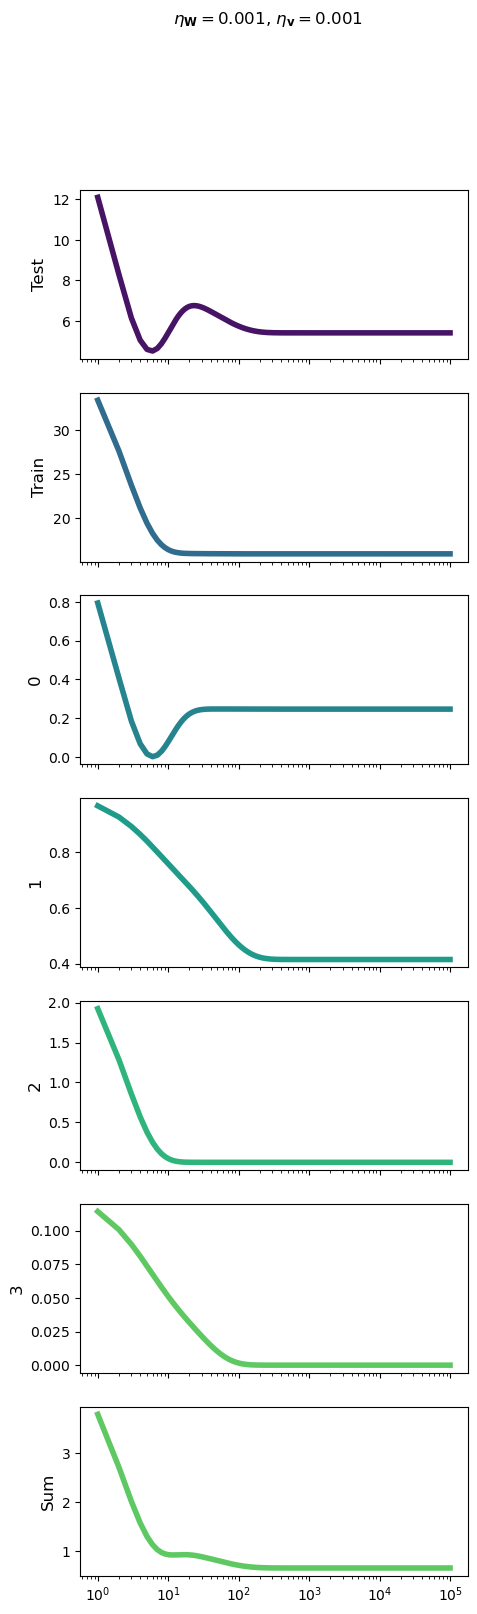

In [29]:
plot_individual_run(0.001, 0.001, batch_norm=False, uniform_noise=True, coupled_noise=None, ext='1.0_dim_2_samples_10_linear_kappa_3.0', plot_extra=True)

In [ ]:
plot_individual_runs_range_kappa(0.001, 0.001, 1, 5, batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10', ymin=[0, 0], ymax=[200, 120])

In [ ]:
plot_results_kappa(0.001, 0.001, vmax=[25, 110], vmin=[5, 80], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10_linear', u=1.0, num_its=100001)

In [ ]:
plot_individual_runs_range_sigma(0.001, 0.001, 0.01, 2, batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_dim_2_linear_kappa_3.0', ymin=[0, 0], ymax=[12, 20])

In [ ]:
plot_results_sigma(0.001, 0.001, vmax=[15, 60], vmin=[0, 0], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_dim_2_linear_kappa_3.0', num_its=100001)

In [ ]:
plot_individual_runs_range(0.001, 1e-7, 9e-6, batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10_linear_kappa_3.0_w_0.1_0.1', ymin=[8, 88], ymax=[15, 102], fixed_lr2=True)

In [75]:
plot_results(0.001,  vmax=[340, 250], vmin=[260, 0], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_100_samples_150_linear_kappa_5.0', num_its=100001, fixed_lr2=False)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
plot_individual_runs_range_pcs(0.0001, 0.0001, 0, 100, batch_norm=False, uniform_noise=True, coupled_noise=10.0, ext='_10.0_dim_100', ymin=[9e3, 0], ymax=[2e4, 10000])

In [ ]:
plot_results_pcs(0.0001, 0.0001, vmax=[9.5e5, 10000], vmin=[9e5, 0], batch_norm=False, uniform_noise=True, coupled_noise=100.0, ext='_10.0_dim_100', num_its=100001)

In [ ]:
for eta_w in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    plot_results(eta_w, 20, plot_nans=False, batch_norm=False)

In [ ]:
plot_same_lr_range(0.01, 0.03, ymin=[5, 80], ymax=[20, 100], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10_linear_kappa_3.0', plot_nans=False, num_its=100001)

In [ ]:
plot_same_lr(vmax=[20, 100], vmin=[5, 80], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10_linear_kappa_3.0', plot_nans=False, num_its=100001)

In [ ]:
plot_individual_runs_range_u(0.001, 0.001, 1, 10, batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_100_samples_150_linear_kappa_5.0_w_0.1_0.1', ymin=[250, 30], ymax=[480, 300])

In [ ]:
plot_results_u(0.001, 0.001, vmax=[480, 300], vmin=[250, 30], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_100_samples_150_linear_kappa_5.0_w_0.1_0.1', num_its=100001)

100.0
1702145023.876615
Lr2 with nan/inf, then some lower lr2
9.54095476
7.543120060000001
5.96362332
4.71486636
3.7275937199999998
2.9470517
2.3299518100000003
1.84206997
1.4563484800000002
1.1513954000000002


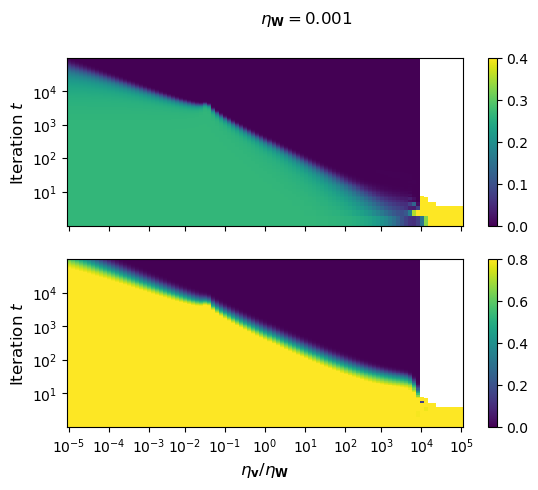

In [83]:
plot_results_weight_eval(0.001, vmax=[0.4, 0.8], vmin=[0, 0], batch_norm=False, uniform_noise=True, coupled_noise=None, ext='_1.0_dim_10_linear_kappa_3.0_w_0.1_0.1', num_its=100001, fixed_lr2=False, step=10)